In [100]:
#CS547 – ADVANCED TOPICS IN SOFTWARE ENGINEERING
#ASSIGNMENT 1 - Part 2
#Group: CS547Assignment1Part2Group47
#Members:
#1. HARSHAN RETHINAVELU SELVAKUMAR – 202480548
#2. MANOJ KUMAR DHARMARAJ - 202468855


In [101]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/matrix/bigfaultmatrixplustime.txt
/kaggle/input/matrix/smallfaultmatrixplustime.txt


In [102]:
#Importing the necessary libraries
import random
import matplotlib.pyplot as plt
from deap import creator,base,tools,algorithms

#Function that loads the data of the file including the execution time
def load_file(filepath):
    
    #Create an empty list
    tests=[]
    
    with open(filepath,'r') as file:
        for line in file:
            
            #Taking each line of the file seperately, removing any leading whitespaces
            #Splitting the line into list of strings using commas
            seperate=line.strip().split(',')
            test_num=seperate[0]
            
            #Faults upto the last element
            fault=list(map(int,seperate[1:-1]))
            
            #Execution time(last element)
            execution_time=float(seperate[-1])
            
            #Adding the test id, fault and execution time 
            tests.append((test_num,fault,execution_time))
            
    return tests

In [103]:
#Fitness function to maximize the number of faults detected and minimize the total execution time

def fit(individual,tests):
    
    #Creating an empty list to store the selected tests
    sel_tests=[]
    
    for i in range(len(individual)):
        if individual[i]==1:
            sel_tests.append(tests[i])
            
    tot_execution_time=0
    
    #Tracking unique faults detected
    detected_faults=set()
    
    #Looping through each selected test
    for _,faults,execution_time in sel_tests:
        tot_execution_time+=execution_time
        
        #Update the list (Unique faults)
        for index,fault in enumerate(faults):
            if fault==1:
                detected_faults.add(index)
                
    #Total number of faults detected
    tot_detected_faults=len(detected_faults)
    
    #Return the objectives
    return tot_detected_faults,tot_execution_time
    

In [104]:
#Creating DEAP classes
creator.create("FitnessMulti",base.Fitness,weights=(1.0,-1.0))
creator.create("Individual",list,fitness=creator.FitnessMulti)

In [105]:
#Defining DEAP toolbox
def tbox(tests):
    toolbox=base.Toolbox()

    toolbox.register("attr_bool",random.randint,0,1)
    toolbox.register("individual",tools.initRepeat,creator.Individual,toolbox.attr_bool,n=len(tests))
    toolbox.register("population",tools.initRepeat,list,toolbox.individual)
    toolbox.register("evaluate",fit,tests=tests)

    #Defining the genetic operators
    toolbox.register("mate",tools.cxUniform,indpb=0.5)
    toolbox.register("mutate",tools.mutFlipBit,indpb=0.2)
    toolbox.register("select",tools.selNSGA2)
    return toolbox

In [106]:
#Genetic Algorithm
def ga(toolbox,tests,pop_size=50,gen=25,cxpb=0.7,mutpb=0.3):
    
    #Initializing the population
    pop=toolbox.population(n=pop_size)
    
    #Evaluating the initial population
    for ind in pop:
        ind.fitness.values=toolbox.evaluate(ind)
            
        
    #Running the GA
    algorithms.eaMuPlusLambda(pop,toolbox,mu=pop_size,lambda_=pop_size,
                              cxpb=cxpb,mutpb=mutpb,ngen=gen,verbose=False)
    
    
    #Pareto Front
    pareto=tools.sortNondominated(pop,len(pop),first_front_only=True)[0]
    
    print(f"\nResults for GA (pop_size={pop_size},gen={gen},cxpb={cxpb},mutpb={mutpb}):")
    print(f"\nTotal final solutions from pareto front:{len(pareto)}")
    
    #Printing the best individuals
    print("Best Individuals in pareto front:")
    
    for i,individual in enumerate(pareto,start=1):
        sel_tests=[tests[index][0] for index,bit in enumerate(individual) if bit==1]
        print(f"\tIndividual{i}:{sel_tests}")
        print(f"\tIndividual{i} Fitness:{individual.fitness.values}\n")

    return pareto
    
    

In [107]:
#Function to compute the metrics from the pareto front
def cal_metrics(pareto):
    
    #Average of faults detected
    faults_avg=np.mean([ind.fitness.values[0] for ind in pareto])
    
    #Average execution time
    time_avg=np.mean([ind.fitness.values[1] for ind in pareto])
    
    #Max of faults detected
    faults_max=max([ind.fitness.values[0] for ind in pareto])
    
    #Minimum execution time
    time_min=min([ind.fitness.values[1] for ind in pareto])
    
    return{"Average of faults detected": faults_avg,
          "Average execution time": time_avg,
          "Max of faults detected": faults_max,
          "Minimum Execution time": time_min}

In [108]:
#Random Search
from deap.creator import Individual
def random_search(tests,runs=10):
    
    #Creating a list to store the results
    result=[]
    for _ in range(runs):
        
        #Random Individual
        individual=[random.randint(0,1) for _ in range(len(tests))]
        
        #Evaluating the fitness
        faults,time=fit(individual,tests)
        
        #Creating DEAP individual
        ind=Individual(individual)
        
        #Fitness
        ind.fitness.values=(faults,time)
        result.append(ind)
    
    #Pareto front
    pareto=tools.sortNondominated([sol for sol in result],len(result),first_front_only=True)[0]
    
    return pareto,result

In [109]:
#Visualization
def visualize(ga_pareto,random_pareto):
    fault_GA=[ind.fitness.values[0] for ind in ga_pareto]
    time_GA=[ind.fitness.values[1] for ind in ga_pareto]
    
    fault_random=[sol[0] for sol in random_pareto]
    time_random=[sol[1] for sol in random_pareto]
    
    plt.figure(figsize=(10,6))
    plt.scatter(time_random,fault_random,label="Random Search",alpha=0.6)
    plt.scatter(time_GA,fault_GA,label="Genetic Algorithm",marker='o',color='red')
    plt.xlabel("Execution Time")
    plt.ylabel("Detected Faults")
    plt.title("Gentic Algorithm vs Random Search")
    plt.legend()
    plt.grid()
    plt.show()


smallfaultmatrixplustime:

Results for GA (pop_size=50,gen=25,cxpb=0.7,mutpb=0.3):

Total final solutions from pareto front:3
Best Individuals in pareto front:
	Individual1:['t0', 't6', 't14', 't19', 't24', 't33', 't36', 't44', 't52', 't56', 't59', 't65', 't67', 't72', 't77', 't88', 't96', 't122', 't124', 't126', 't129', 't134', 't141', 't146', 't148', 't149', 't150', 't151', 't161', 't162', 't168', 't175', 't180', 't182', 't183', 't190', 't191', 't192', 't195', 't197', 't199', 't203', 't204', 't215']
	Individual1 Fitness:(8.0, 193.0)

	Individual2:['t0', 't1', 't6', 't14', 't16', 't20', 't24', 't32', 't35', 't36', 't44', 't52', 't59', 't73', 't77', 't88', 't91', 't96', 't100', 't108', 't124', 't126', 't129', 't134', 't142', 't143', 't144', 't148', 't149', 't152', 't161', 't162', 't164', 't168', 't174', 't180', 't183', 't184', 't187', 't191', 't192', 't195', 't196', 't197', 't199', 't206', 't215']
	Individual2 Fitness:(7.0, 180.0)

	Individual3:['t0', 't1', 't4', 't6', 't14', 't16', '

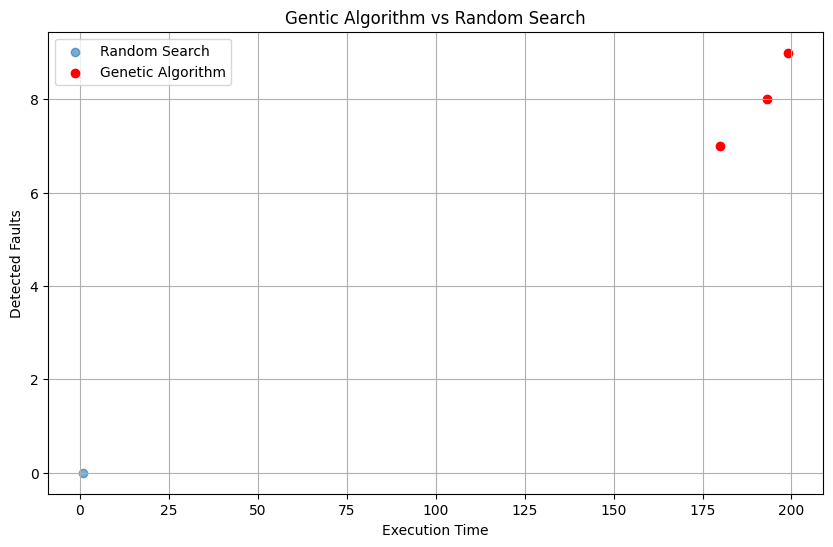


Results for GA (pop_size=50,gen=25,cxpb=0.6,mutpb=0.4):

Total final solutions from pareto front:2
Best Individuals in pareto front:
	Individual1:['t0', 't3', 't4', 't11', 't12', 't15', 't16', 't27', 't35', 't36', 't37', 't42', 't43', 't44', 't45', 't48', 't49', 't50', 't55', 't56', 't66', 't72', 't79', 't82', 't87', 't88', 't94', 't113', 't128', 't132', 't135', 't136', 't145', 't146', 't147', 't150', 't151', 't155', 't160', 't162', 't164', 't166', 't168', 't169', 't183', 't186', 't191', 't192', 't195', 't200', 't211', 't213', 't214', 't215']
	Individual1 Fitness:(9.0, 245.0)

	Individual2:['t0', 't1', 't12', 't30', 't35', 't36', 't37', 't42', 't44', 't45', 't49', 't50', 't52', 't54', 't57', 't62', 't63', 't71', 't72', 't77', 't84', 't85', 't86', 't87', 't88', 't99', 't113', 't119', 't120', 't127', 't129', 't130', 't131', 't140', 't143', 't145', 't147', 't149', 't151', 't162', 't164', 't166', 't168', 't169', 't173', 't183', 't192', 't196', 't203', 't213', 't215']
	Individual2 Fitness:

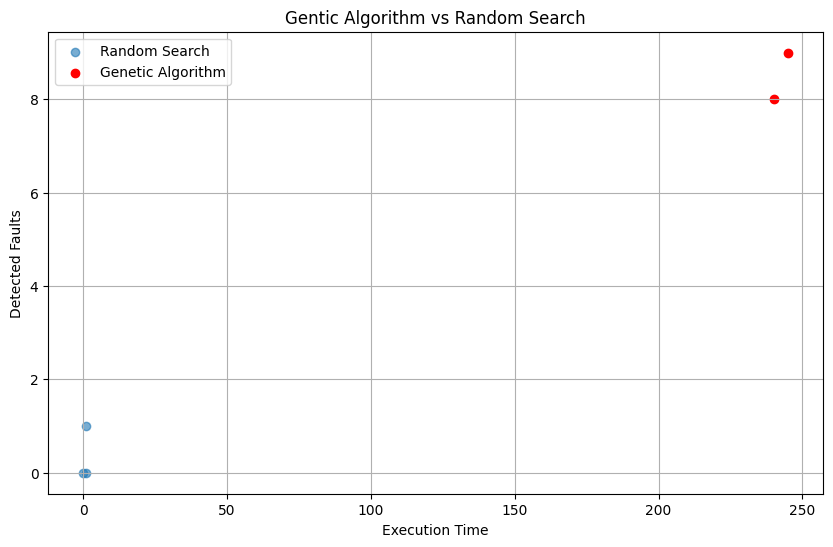


Results for GA (pop_size=50,gen=25,cxpb=0.8,mutpb=0.2):

Total final solutions from pareto front:2
Best Individuals in pareto front:
	Individual1:['t1', 't4', 't13', 't15', 't24', 't28', 't31', 't35', 't36', 't41', 't50', 't52', 't54', 't59', 't61', 't69', 't78', 't84', 't86', 't89', 't92', 't95', 't98', 't102', 't109', 't112', 't123', 't126', 't131', 't134', 't135', 't147', 't152', 't156', 't162', 't166', 't167', 't183', 't190', 't191', 't195', 't197', 't205', 't207', 't215']
	Individual1 Fitness:(8.0, 162.0)

	Individual2:['t3', 't6', 't12', 't13', 't15', 't28', 't31', 't34', 't36', 't48', 't52', 't58', 't59', 't62', 't69', 't78', 't84', 't85', 't87', 't89', 't100', 't102', 't107', 't120', 't121', 't123', 't125', 't131', 't133', 't143', 't147', 't150', 't152', 't158', 't160', 't166', 't168', 't174', 't177', 't178', 't183', 't190', 't191', 't193', 't197', 't204', 't205', 't207', 't208', 't213']
	Individual2 Fitness:(9.0, 210.0)


GA Metrics:
{'Average of faults detected': 8.5, 'Avera

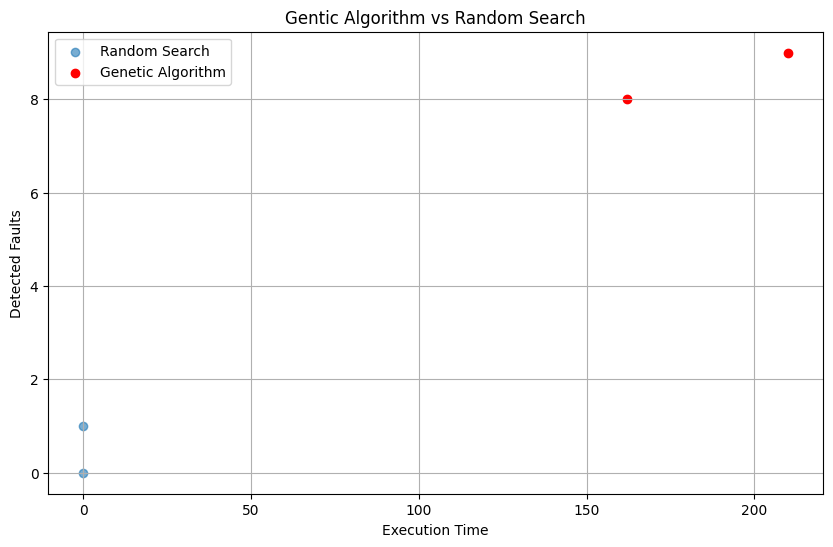


bigfaultmatrixplustime:

Results for GA (pop_size=50,gen=25,cxpb=0.7,mutpb=0.3):

Total final solutions from pareto front:3
Best Individuals in pareto front:
	Individual1:['t1', 't10', 't1000', 't10001', 't10007', 't10009', 't10010', 't10013', 't10015', 't10017', 't10020', 't10021', 't10024', 't10027', 't10028', 't10033', 't10036', 't10037', 't10039', 't10045', 't1005', 't10052', 't10054', 't10055', 't10057', 't10058', 't1006', 't10064', 't10066', 't10068', 't10072', 't10076', 't1009', 't10090', 't10092', 't10093', 't10100', 't10101', 't10103', 't10105', 't10110', 't10114', 't10116', 't10117', 't10118', 't10119', 't10120', 't10121', 't10124', 't10126', 't10128', 't10129', 't10130', 't10135', 't10137', 't10142', 't10145', 't10149', 't10152', 't10160', 't10161', 't10169', 't1017', 't10173', 't10175', 't10176', 't10179', 't10181', 't10185', 't10187', 't10188', 't1019', 't10191', 't10192', 't10194', 't10195', 't10199', 't10201', 't10202', 't10203', 't10205', 't10207', 't10211', 't10215', 

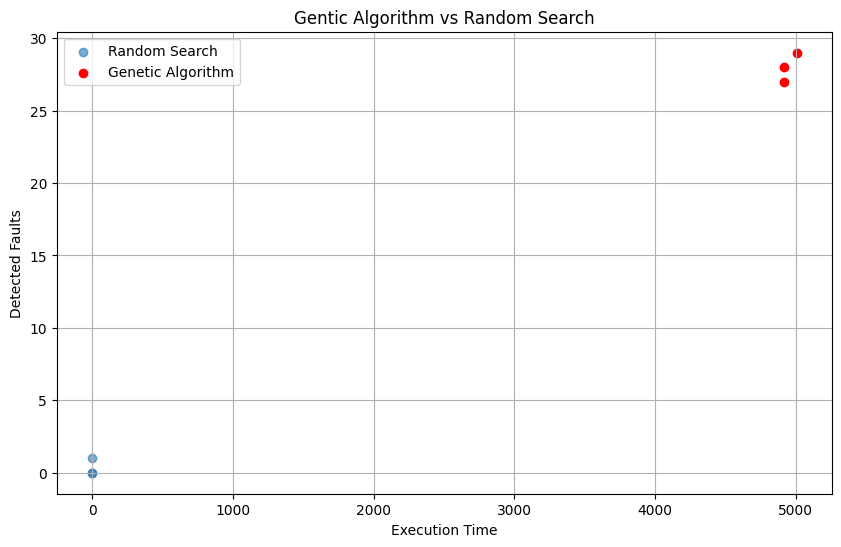


Results for GA (pop_size=50,gen=25,cxpb=0.6,mutpb=0.4):

Total final solutions from pareto front:3
Best Individuals in pareto front:
	Individual1:['t100', 't10000', 't10001', 't10004', 't10007', 't10009', 't10012', 't10013', 't10014', 't10015', 't10021', 't10023', 't10025', 't10026', 't10029', 't10035', 't10037', 't10039', 't10040', 't10044', 't10046', 't1005', 't10050', 't10056', 't10057', 't10059', 't1006', 't10061', 't10064', 't10067', 't10068', 't10070', 't10073', 't10077', 't10079', 't10086', 't10087', 't10088', 't10096', 't10098', 't101', 't10106', 't10107', 't10108', 't10109', 't10110', 't10111', 't10112', 't10116', 't10118', 't10119', 't10120', 't10123', 't10124', 't10125', 't10128', 't1013', 't10131', 't10133', 't10137', 't10138', 't1014', 't10143', 't10148', 't10149', 't10150', 't10154', 't10155', 't10161', 't10163', 't10167', 't10168', 't10169', 't1017', 't10173', 't10174', 't10176', 't10178', 't1018', 't10181', 't10182', 't10188', 't10190', 't10191', 't10194', 't10195', 't

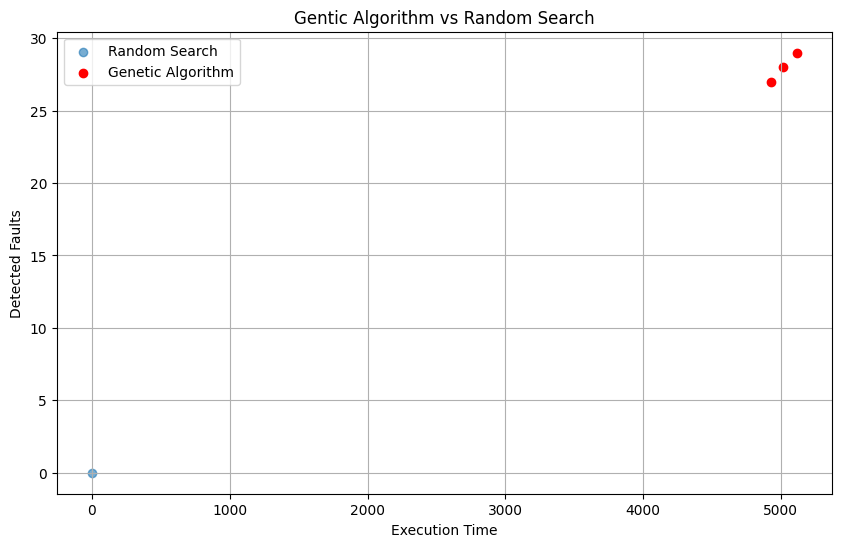


Results for GA (pop_size=50,gen=25,cxpb=0.8,mutpb=0.2):

Total final solutions from pareto front:1
Best Individuals in pareto front:
	Individual1:['t1000', 't10003', 't10007', 't10009', 't10011', 't10016', 't10017', 't10022', 't10029', 't10032', 't10036', 't1004', 't10045', 't10048', 't10052', 't10057', 't10060', 't10061', 't10067', 't10070', 't10071', 't10074', 't10076', 't10079', 't10093', 't10094', 't1010', 't10106', 't10107', 't10112', 't10114', 't10117', 't10119', 't1012', 't10120', 't10123', 't10124', 't10129', 't10131', 't10137', 't10144', 't10146', 't10147', 't10148', 't10149', 't1015', 't10151', 't10155', 't10158', 't10161', 't10164', 't10165', 't10168', 't10169', 't10175', 't10180', 't10188', 't1019', 't10190', 't10194', 't10195', 't10196', 't102', 't10200', 't10204', 't10205', 't10207', 't1021', 't10210', 't10218', 't10219', 't10223', 't10229', 't10230', 't10234', 't10235', 't10238', 't1024', 't10241', 't10243', 't10247', 't10249', 't10250', 't10251', 't10253', 't10254', 't

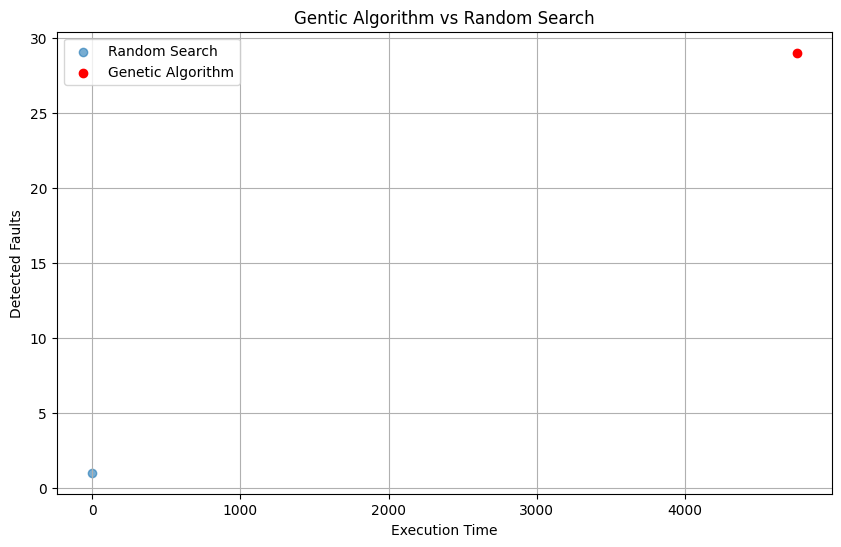

In [110]:
#Main funtion
if __name__=="__main__":
    
    #Reading the datasets
    test1=load_file("/kaggle/input/matrix/smallfaultmatrixplustime.txt")
    test2=load_file("/kaggle/input/matrix/bigfaultmatrixplustime.txt")
    
    #Parameters sets for diverse solutions
    parameters=[{"pop_size":50,"gen":25,"cxpb":0.7,"mutpb":0.3},
               {"pop_size":50,"gen":25,"cxpb":0.6,"mutpb":0.4},
               {"pop_size":50,"gen":25,"cxpb":0.8,"mutpb":0.2},]
    
    #Using for loop to go through the datasets and parameters
    for dataset,tests in [("smallfaultmatrixplustime",test1),("bigfaultmatrixplustime",test2)]:
        print(f"\n{dataset}:")
        
        #Creating toolbox
        toolbox=tbox(tests)
        
        for parameter in parameters:
            
            #Genetic Algorithm...
            pareto=ga(toolbox,tests,pop_size=parameter["pop_size"],
                      gen=parameter["gen"],cxpb=parameter["cxpb"],mutpb=parameter["mutpb"])
            
            #Computing metrics for GA
            ga_metrics=cal_metrics(pareto)
            print(f"\nGA Metrics:" )
            print(ga_metrics)
            
            #Random Search...
            pareto_random,result=random_search(tests,runs=10)
            
            #Visualizing the results
            visualize(pareto,pareto_random)

In [ ]:
#References
#https://github.com/DEAP/deap
#https://advancedoracademy.medium.com/multi-objective-optimization-a-comprehensive-guide-with-python-example-09edc2af03f3
#http://deap.gel.ulaval.ca/doc/default/api/algo.html